# Lab Week 12 - using a pretrained model

## Tranfer learning

Usually we use a combination of a convolutional network that extracts abstract features from the image and a fully connected part (often called "top") that uses those features for classification.

![](https://www.mcpressonline.com/images/thumbnails/thumb_20230621SandersFig2.JPG)


## ImageNet
ImageNet is a large dataset of over 14 million labeled images organized according to the WordNet hierarchy. It's a crucial resource for training and evaluating computer vision models, particularly deep learning models. By providing a standardized dataset with high-quality annotations, ImageNet has significantly accelerated progress in image classification, object detection, and other vision tasks.

https://en.wikipedia.org/wiki/ImageNet

![](https://blog.roboflow.com/content/images/size/w1000/2021/06/image-18.png)

## VGG Net
[VGG16](https://en.wikipedia.org/wiki/VGGNet), published in 2014, achieved top ranks in a competition for classifying ImageNet images into 1000 categories.

Architecture of VGG16:

![](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)

## Reusing pre-trained networks
Trainig a fairly large network like VGG16 on the 14 million images from ImageNet takes considerable time and resources but results in a CNN that can reliably recognize a large set of features in any image. It is very useful to utilize this pre-trained network for feature detection in any images that might resemble those from ImageNet and then train a new fully connected network to classify the images using these features.


![](https://dev-to-uploads.s3.amazonaws.com/i/2oyycxxs02jmcghplwc4.png)




## Setp 1: Loading the data - same as last week

We will be using the same cats and dogs dataset from the last week, but downloded in simpler way.

In [1]:
## Download a zip with a subset of the cats and dogs from Gootl Drive
!gdown 1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS

Downloading...
From (original): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS
From (redirected): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS&confirm=t&uuid=c2e6e500-d5c6-45ec-80af-a4c84dd79089
To: /content/catsVdogs_small.zip
100% 114M/114M [00:00<00:00, 189MB/s]


In [2]:
!unzip -o -q catsVdogs_small.zip

### Data preprocessing (For this section just run the cells)

**Copying images to training, validation, and test directories**

In [3]:
# imports and setup

import numpy as np
import matplotlib.pylab as plt

import os, shutil, pathlib

import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path('small')


**Using `image_dataset_from_directory` to read images**

In [4]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Displaying the the data and labels yielded by the `Dataset`

`train_dataset`, `validation_dataset`, and `test_dataset` behave like a **generator** in the sense that it **yields data lazily** when iterated over, instead of loading everything into memory at once.

**TODO: Iterate over `train_dataset` and take one sample batch and labels, print the shape of the batch and save it in `sample_batch` variable**

In [ ]:
#your code

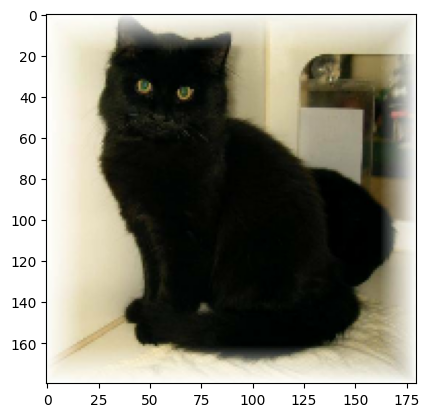

In [6]:
import matplotlib.pylab as plt
plt.imshow(sample_batch[10].numpy().astype("uint8"))

## Step 2: Load the pretrained VGG16 model from Keras

**Instantiating the VGG16 convolutional base**

In [7]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [8]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Step 3:  Feature extraction with a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [9]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

**TODO:Explore the shape and size of the extracted features**

In [ ]:
#your code here

## Step 4- Pipeline A:
## Definine and train the densely connected classifier that uses the extracted features as input

**TODO: Define and compile the model to classify pictures as cats vs dogs**
- What will be the size of the output layer?
- What activation function should the output layer use?
- What loss function should be used?
- Layers to use
  - Flatten as the first layer to reshape the feature maps returned by the CSS into 1-D arrays
  - Dense layer with 128 neurons
  - Dropout layer with 30% to 50% dropout rate
  - Output layer
- Don't forget to add `accuracy` metric when compiling the model

In [ ]:
# your code here


**Plotting the results**

**TODO: Plot the history of loss and accuracty as we did in the previous labs**

In [ ]:
#your code here

**Evaluate the model using test data**

In [15]:
#your code here

## Step 4- Pipeline B:
## Feature extraction together with classifier in a single architecture

**Instantiating and freezing the VGG16 convolutional base**

In [17]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False) ## this means we only get the convolutional part without the densely connected top


conv_base.trainable = False ## This freezes the wieghts on the convolutional part

**Printing the list of trainable weights before and after freezing**

In [18]:
conv_base.trainable = True
print("This is the number of trainable weight tensors "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors before freezing the conv base: 26


**In order to calculate the number of trainable parameters we need to add up the size of each tensor. try running this with the layers fronzen and unfrozen and compare to the number returned by `conv_base.summary()`**

In [20]:
trainable_params = 0
for layer in conv_base.trainable_weights:
  trainable_params += layer.numpy().size

print(f'Number of trainable parameters is {trainable_params}')


Number of trainable parameters is 14714688


In [21]:
conv_base.trainable = False
print("This is the number of trainable weight tensors "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors after freezing the conv base: 0


**Frozen ConvNet and densely connected network in a single architecture**

In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)

x = conv_base(x) # Convolutional base

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)
model2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [26]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │      3,277,056 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            257 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,269,316 (81.14 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,277,315 (12.50 MB)

**This model (Pipeline B) is exactly the same as what you did for Pipeline A.**

**TODO: Train `model2`, evaluate the trained model, and plot the results.**

In [ ]:
#your code here